<a href="https://colab.research.google.com/github/rubyvanrooyen/ARIWS-Cookbook/blob/main/0-Introduction/Sampling_theorem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Sampling Theorem

This notebook takes a look at the Nyquist-Shannon Sampling Theorem, from a Fourier perspective.

A simple statement of the Sampling theorem is: <br/>
The sampling frequency should be at least twice the highest frequency contained in the signal.

The sample frequency which meets this requirement is called the Nyquist frequency, and its reciprocal is the Nyquist rate, which is the rate the signal should be sampled at to avoid aliasing.

So if the highest frequency in our signal is $\nu_{max}$, our Nyquist frequency is $2\times\nu_{max}$, and our Nyquist rate, the rate we need to sample the signal at, is $\Delta t = 1/ (2 \nu_{max})$. 

In [1]:
import numpy as np
import matplotlib.pylab as plt

Make our convenience functions using the fourier transform provided by numpy:

In [2]:
def ft(y):
    """Returns the fourier transform of y"""
    return np.fft.fftshift(np.fft.fft(np.fft.fftshift(y)))

def ift(y):
    """Returns the inverse fourier transform of y"""
    return np.fft.fftshift(np.fft.ifft(np.fft.fftshift(y)))

def ftfreqs(N,dt):
    """Returns the Fourier frequencies"""
    return np.fft.fftshift(np.fft.fftfreq(N,dt))

Lets define some of the frequently used functions again, so we can play with them:

In [3]:
# gaussian function
def gaussian(t,sigma):
    return (1./(np.sqrt(2.*np.pi)*sigma))*np.exp(-t**2.0/(2.*sigma**2.0))

In [4]:
# comb function
def comb(t,t_space,A):
    output = np.zeros(len(t))
    mod_array = np.array([round(i,2)%t_space for i in t])
    output[mod_array==0] = A
    return output

In [5]:
# top-hat function
def tophat(t,width,A):
    output = np.zeros(len(t))
    output[abs(t)<width/2.0] = A
    return output

What are we sampling?    
Radio telescopes measure the antenna response pattern, which is basically a sinc function and the inverse Fourier transform of the signal we are observing.
Where the signal we are observing is the plane wave illuminating the dish aperture.
For parabolic dishes such as MeerKAT, this looks like a cosine-tapered amplitude.

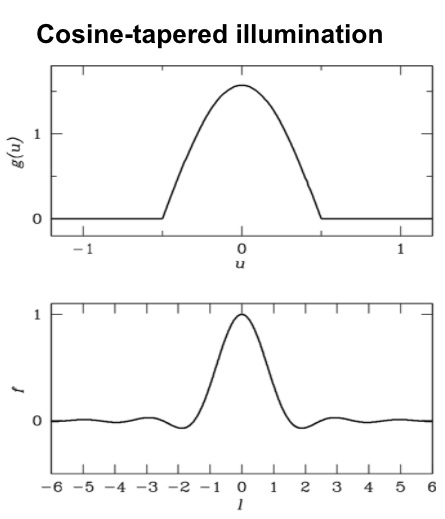

According to the similarity theorem, a wide Gaussian in the time domain will result in a narrower and taller Gaussian in the frequency domain, while a narrow Gaussian in the time domain will be a wider, shorter Gaussian in the Fourier domain, always conserving the area under the function through the transform.
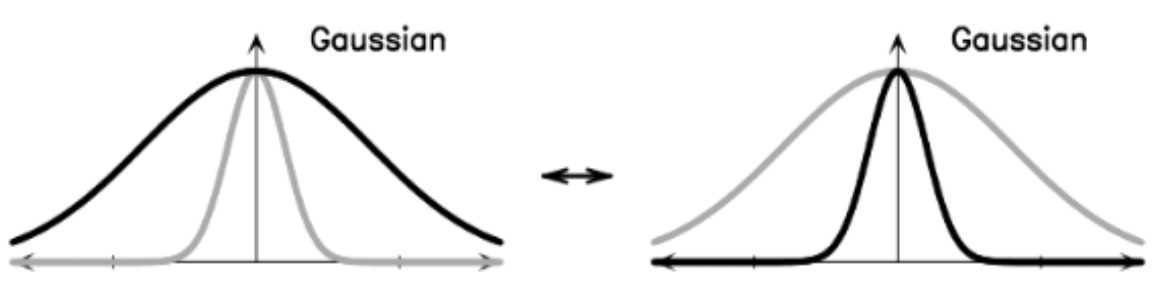

Which is what we see in our data, with:
* the beamwidth of an aperture antenna inversely proportional to the projected aperture size in wavelengths, while
* the on-axis field strength is directly proportional to the projected aperture size in wavelengths.

Thus, through the similarity theorem we obtain a general scaling relation between the dishes main beam size and the observation wavelength.
$\Theta_{HPBW}\approx1.2*(\lambda/D)$

Let's create and sample our signals...

Lets create a function that is a Gaussian, but with a frequency cutoff.
We can do this by multiplying our function by a tophat function in the Fourier domain.

Start off with setting up our x-axis values:
(Disclaimer - the time range set here is actually a bit of a cheat. We want to set it to an integral number of the shah/comb period we use later, just to avoid FFT folding effects. So we chose this number to be an integral multiple of the comb period we use later.)

In [6]:
delta_t = 1.0
t = np.arange(-780,780,delta_t)              # set x-axis value

freqs = ftfreqs(len(t),delta_t)              # get our Fourier transform frequency values

Start with a Gaussian of sigma 50.0.
The Fourier transform of a Gaussian with standard deviation of $\sigma_0$ is $1/(2*\pi*\sigma_0)$.
So the Fourier transform of our Gaussian will have a standard deviation of $1/(2*\pi*5)$.

Lets cut the frequency of at, say, 2.0 times the Fourier domain standard deviation.

In [7]:
sig_0 = 50.0
h = gaussian(t,sig_0)                          # create gaussian function 
 
H = ft(h)                                      # Fourier transform

sig_f = 1/(2.*np.pi*sig_0)
print(f'time domain standard deviation: {sig_0}')
print(f'frequency domain standard deviation: {sig_f}')

f_max = 2.0*sig_f
print(f'maximum frequency for our signal: {f_max}')

filter = tophat(freqs,2*f_max,1.0)             # create a top hat from -f_max to f_max, total width 2*f_max 
H_flimit = H*filter                            # multiply our FT by the top hat to cut off frequencies > f_max

h_flimit = ift(H_flimit)

time domain standard deviation: 50.0
frequency domain standard deviation: 0.0031830988618379067
maximum frequency for our signal: 0.006366197723675813


Now lets plot our Gaussian and our chopped-off Gaussian, to check:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


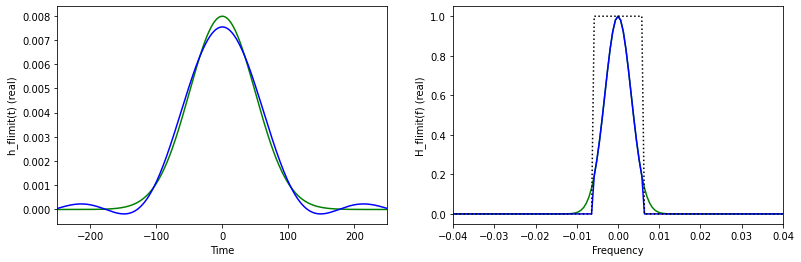

In [8]:
fig, ax = plt.subplots(1,2,figsize=[13,4])     # create plot

ax[0].plot(t,h,'g')
ax[0].plot(t,h_flimit,'b')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('h_flimit(t) (real)')

ax[1].plot(freqs,H.real,'g')
ax[1].plot(freqs,H_flimit.real,'b')
ax[1].plot(freqs,filter,'k:')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('H_flimit(f) (real)')

ax[0].set_xlim(-250.,250.)
ax[1].set_xlim(-0.04,0.04)
plt.show()

We will use our frequency-limited function `h_flimit` hereafter.

The sampling theorem says we should sample at a frequency of double our max frequency to fully reconstruct our signal. So lets do that first.

In [9]:
sample_freq = 2*f_max
sample_period = 1/sample_freq

print(f'Sample frequency: {sample_freq}')
print(f'Sample period: {sample_period}')

Sample frequency: 0.012732395447351627
Sample period: 78.53981633974483


We will use a shah / comb function to sample our time-domain function at the sample frequency we want.
We do this by multiplying our time-domain signal by the comb to select a subset of points at regular spacings (sample it!)

Because of how we have defined our comb function, we want to use an integer sample period.
So we will round our desired sample period down (still good enough for illustrative purposes!)

Integer sample period: 78.0


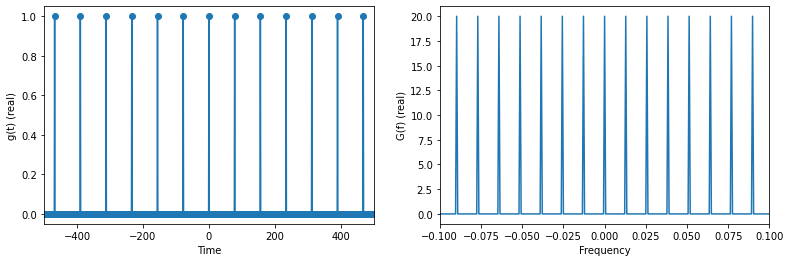

In [10]:
sample_period = np.floor(sample_period)           # round down to get integer comb period

print(f'Integer sample period: {sample_period}')

g = comb(t,sample_period,1.0)                      
G = ft(g)                                      # Fourier transform

fig, ax = plt.subplots(1,2,figsize=[13,4])     # create plot

ax[0].plot(t,g,'o-')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('g(t) (real)')

ax[1].plot(freqs,G.real)
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('G(f) (real)')

ax[0].set_xlim(-500.,500.)
ax[1].set_xlim(-0.1,0.1)
plt.show()

Now multiply our frequency limited signal `h_flimit` by our sampling function comb, to sample our signal at the desired sampling period, then Fourier transform it:

In [11]:
y = h_flimit*g

# then Fourier transform:
Y = ft(y)

Now plot our original (top) and sampled (bottom) time-domain function (left) and its Fourier transform (right). 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


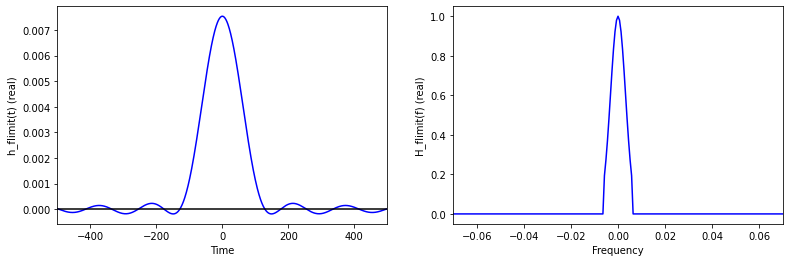

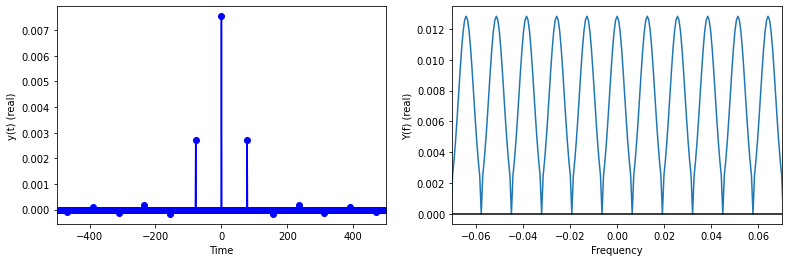

In [12]:
fig, ax = plt.subplots(1,2,figsize=[13,4])     # create plot

ax[0].plot(t,h_flimit,'b')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('h_flimit(t) (real)')
ax[0].axhline(y=0,color='k')

ax[1].plot(freqs,H_flimit.real,'b')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('H_flimit(f) (real)')
ax[0].set_xlim(-500.,500.)
ax[1].set_xlim(-0.07,0.07)

fig, ax = plt.subplots(1,2,figsize=[13,4])     # create plot

ax[0].plot(t,y,'b-o')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('y(t) (real)')

ax[1].plot(freqs,Y.real)
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Y(f) (real)')
ax[1].axhline(y=0,color='k')

ax[0].set_xlim(-500.,500.)
ax[1].set_xlim(-0.07,0.07)
plt.show()

You can see on the left how multiplication by the comb has sampled our original (top) function. On the right you can see how this sampling has led to the function being repeated across the Fourier-domain function (because of the Convolution theorem!)

On the right we see that our functions just avoid overlapping - that is because we samped at the Nyquist rate. 

Now lets see what happens if we sample at a lower rate than the nyquist rate. Let's re-do the exercise above using a sample period of 100 (the Nyquist sample rate above is 78.5).

Set up our new time array (it is a cheat again - now a multiple of 100).

In [13]:
delta_t = 1.0
t = np.arange(-800,800,delta_t)              # set x-axis value

freqs = ftfreqs(len(t),delta_t)                # get our Fourier transform frequency values

Create our functions again, using the same parameters but our new time array:

In [14]:
h = gaussian(t,sig_0)                          # create gaussian function 
 
H = ft(h)                                      # Fourier transform

filter = tophat(freqs,2*f_max,1.0)             # create a top hat from -f_max to f_max, total width 2*f_max 
H_flimit = H*filter                            # multiply our FT by the top hat to cut off frequencies > f_max

h_flimit = ift(H_flimit)

Plot our functions again:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


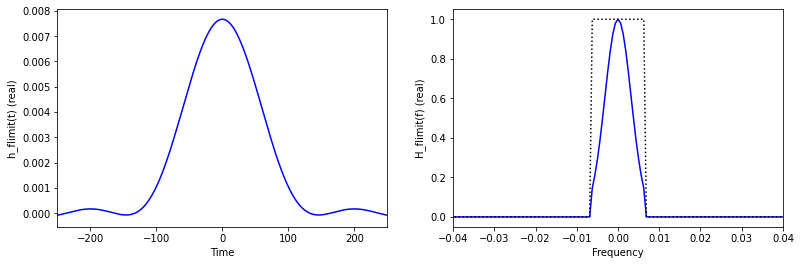

In [15]:
fig, ax = plt.subplots(1,2,figsize=[13,4])     # create plot

ax[0].plot(t,h_flimit,'b')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('h_flimit(t) (real)')

ax[1].plot(freqs,H_flimit.real,'b')
ax[1].plot(freqs,filter,'k:')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('H_flimit(f) (real)')

ax[0].set_xlim(-250.,250.)
ax[1].set_xlim(-0.04,0.04)
plt.show()

Set up our sampling comb and plot it:

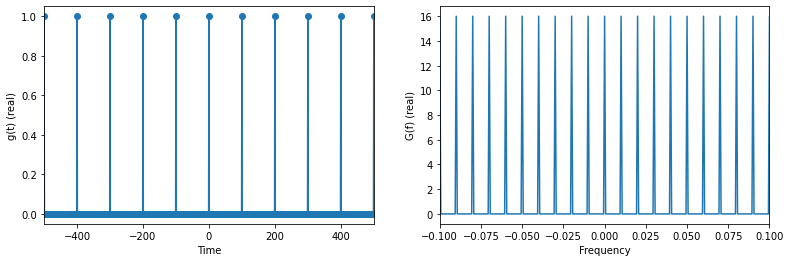

In [16]:
sample_period = 100

g = comb(t,sample_period,1.0)                  
G = ft(g)                                      # Fourier transform

fig, ax = plt.subplots(1,2,figsize=[13,4])     # create plot

ax[0].plot(t,g,'o-')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('g(t) (real)')

ax[1].plot(freqs,G.real)
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('G(f) (real)')

ax[0].set_xlim(-500.,500.)
ax[1].set_xlim(-0.1,0.1)
plt.show()

Now multiply our frequency limited signal `h_flimit` by our sampling function comb, to sample our signal at the desired sampling period, then Fourier transform it:

In [17]:
y = h_flimit*g

# then Fourier transform:
Y = ft(y)

Now plot our original (top) and sampled (bottom) time-domain function (left) and its Fourier transform (right), as we did before: 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


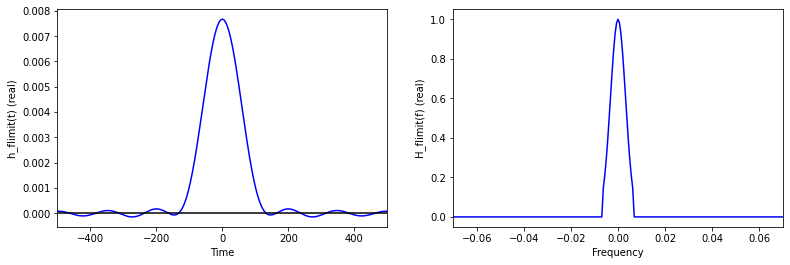

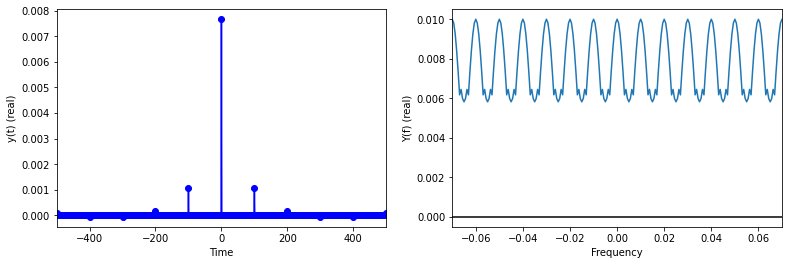

In [18]:
fig, ax = plt.subplots(1,2,figsize=[13,4])     # create plot

ax[0].plot(t,h_flimit,'b')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('h_flimit(t) (real)')
ax[0].axhline(y=0,color='k')

ax[1].plot(freqs,H_flimit.real,'b')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('H_flimit(f) (real)')
ax[0].set_xlim(-500.,500.)
ax[1].set_xlim(-0.07,0.07)

fig, ax = plt.subplots(1,2,figsize=[13,4])     # create plot

ax[0].plot(t,y,'b-o')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('y(t) (real)')

ax[1].plot(freqs,Y.real)
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Y(f) (real)')
ax[1].axhline(y=0,color='k')

ax[0].set_xlim(-500.,500.)
ax[1].set_xlim(-0.07,0.07)
plt.show()

In the Fourier domain the repeating functions now overlap, with the signal added where they overlap. Part of the signal from the higher frequency end overlaps with the lower frequency end, for each repeat of the Fourier-domain function. 

The original signal can't be recovered.